In [138]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Data Cleaning
---

In [139]:
# load the data
df = pd.read_csv("private_folder/country_fdi.csv", low_memory=False)

In [140]:
df.columns

Index(['Time', 'Time Code', 'Country Name', 'Country Code',
       'GDP (constant 2015 US$) [NY.GDP.MKTP.KD]',
       'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]',
       'Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]',
       'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
       'GDP deflator (base year varies by country) [NY.GDP.DEFL.ZS]',
       'Gross capital formation (% of GDP) [NE.GDI.TOTL.ZS]',
       'Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate) [SL.EMP.TOTL.SP.ZS]',
       'Population, total [SP.POP.TOTL]',
       'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]'],
      dtype='object')

In [141]:
# rename the columns
col_names = ['time', 'time_code', 'country', 'country_code', 'gdp', 'gdp_per_capita', 'import_to_gdp', 'export_to_gdp', 'inflation_gdp_deflator', 'gross_capital_forma_gdp', 'unemployment', 'employment_15', 'population', 'fdi']

df_rename = df.copy()
df_rename.columns = col_names

# sort the data
df_rename.sort_values(by=['country_code', 'time'], inplace=True)

# choose only OECD countries
oecd_countries_iso3 = [
    "AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CRI", "CZE", "DNK", "EST", 
    "FIN", "FRA", "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", 
    "KOR", "LVA", "LTU", "LUX", "MEX", "NLD", "NZL", "NOR", "POL", "PRT", 
    "SVK", "SVN", "ESP", "SWE", "CHE", "TUR", "GBR", "USA"]

# choose only OECD countries
df_oecd = df_rename[df_rename['country_code'].isin(oecd_countries_iso3)].copy()

# convert date to datetime
df_oecd['time'] = pd.to_datetime(df_oecd['time'], format='%Y').dt.year

# replace '..' with np.nan
df_oecd = df_oecd.replace('..', np.nan)

# drop columns
df_oecd = df_oecd.drop(columns=['time_code'])

# convert to float
cols = ['gdp', 'gdp_per_capita', 'import_to_gdp', 'export_to_gdp', 'inflation_gdp_deflator', 'gross_capital_forma_gdp', 'unemployment', 'employment_15', 'population', 'fdi']
df_oecd[cols] = df_oecd[cols].astype(float)

# gen log gdp, log gdp_percap
df_oecd['log_gdp'] = np.log(df_oecd['gdp'])
df_oecd['log_gdp_percap'] = np.log(df_oecd['gdp_per_capita'])
df_oecd['log_population'] = np.log(df_oecd['population'])

In [143]:
# checkout country's fdi data 
df_oecd[['country', 'time', 'fdi']].query('country == "Luxembourg"').head(10)

,country,time,fdi
116,Luxembourg,1995,NaN
382,Luxembourg,1996,NaN
648,Luxembourg,1997,NaN
914,Luxembourg,1998,NaN
1180,Luxembourg,1999,NaN
1446,Luxembourg,2000,NaN
1712,Luxembourg,2001,NaN
1978,Luxembourg,2002,17.941667
2244,Luxembourg,2003,14.464108
2510,Luxembourg,2004,14.771614


In [144]:
# if country has missing value in fdi, drop the country
df_oecd = df_oecd.groupby('country').filter(lambda x: x['fdi'].notna().all())

# add the treated column
df_oecd['tr_group'] = np.where(df_oecd['country_code'] == 'GBR', 1, 0)
# add post period column
df_oecd['post_period'] = np.where(df_oecd['time'] >= 2017, 1, 0)
# add treated post column
df_oecd['treated'] = df_oecd['tr_group'] * df_oecd['post_period']

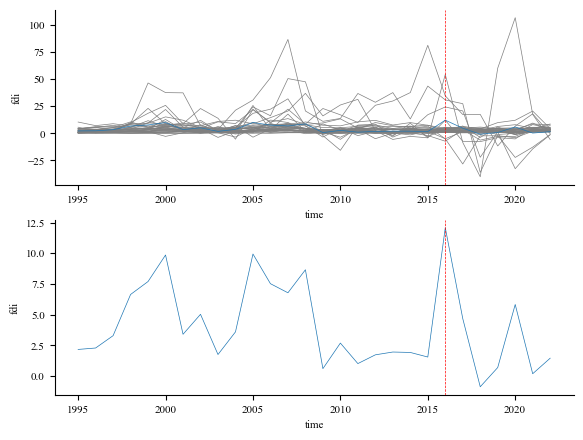

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_oecd.query("tr_group==0"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

In [146]:
# Define the range condition
def check_fdi_outside_range(group):
    return (group['fdi'] < -25) | (group['fdi'] > 25)

# Group by 'country' and check if any value is outside the range
countries_with_out_of_range_values = df_oecd.groupby('country').apply(lambda x: check_fdi_outside_range(x).any())

# List of countries to drop
countries_to_drop = countries_with_out_of_range_values[countries_with_out_of_range_values].index

# Drop these countries from the DataFrame
df_drop_extrem = df_oecd[~df_oecd['country'].isin(countries_to_drop)].copy()

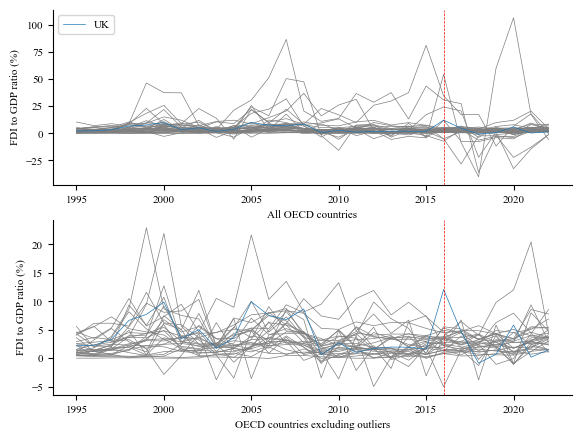

In [157]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_oecd.query("tr_group==0"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5, label='UK')
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
ax[0].set(ylabel='FDI to GDP ratio (%)', xlabel='All OECD countries')

sns.lineplot(data=df_drop_extrem.query("tr_group==0"), x='time', y='fdi', ax=ax[1], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_drop_extrem.query("tr_group==1"), x='time', y='fdi', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)
ax[1].set(ylabel='FDI to GDP ratio (%)', xlabel='OECD countries excluding outliers')

sns.despine()
# Save the figure
plt.savefig('figs/fdi_oecd.png', dpi=300)

In [148]:
print(countries_to_drop)

Index(['Austria', 'Belgium', 'Hungary', 'Iceland', 'Ireland', 'Netherlands',
       'Switzerland'],
      dtype='object', name='country')


In [149]:
df_drop_extrem.country.nunique()

30

### 1. Estimate the treatment effect using the CSC-IPCA model
---

In [150]:
from src.csc_ipca import CSC_IPCA
from src.csc_ife import CSC_IFE
from src.scm import SCM
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [151]:
df_drop_extrem.columns

Index(['time', 'country', 'country_code', 'gdp', 'gdp_per_capita',
       'import_to_gdp', 'export_to_gdp', 'inflation_gdp_deflator',
       'gross_capital_forma_gdp', 'unemployment', 'employment_15',
       'population', 'fdi', 'log_gdp', 'log_gdp_percap', 'log_population',
       'tr_group', 'post_period', 'treated'],
      dtype='object')

In [152]:
# gen a list of covariates
covariates = ['log_gdp', 'log_gdp_percap', 'import_to_gdp', 'export_to_gdp', 'inflation_gdp_deflator',  'gross_capital_forma_gdp', 'unemployment', 'employment_15', 'log_population']

# copy the prepared data for estimation
data = df_drop_extrem.copy()
#scaler = StandardScaler()
#data[covariates] = scaler.fit_transform(data[covariates])

# initiate the model
model = CSC_IPCA()
# set the number of principal components
K=2

# fit the model
model.fit(data, 'country', 'time', 'fdi', 'treated', covariates, K, verbose=True)
results = data.query("country == 'United Kingdom'")[['time', 'fdi']]
results['Y_syn'] = model.predict().flatten()
results['residual'] = results['fdi'] - results['Y_syn'] 

iter 0: tol_Gama: 0.04950248030364994, tol_F: 8.095960090271259
iter 1: tol_Gama: 0.02273417447000701, tol_F: 3.4796043676997
iter 2: tol_Gama: 0.011999848022471914, tol_F: 1.6057897140980266
iter 3: tol_Gama: 0.005658342418928122, tol_F: 1.0139996647838991
iter 4: tol_Gama: 0.002614322630945156, tol_F: 0.5999127319794022
iter 5: tol_Gama: 0.0012092790034331736, tol_F: 0.3426522578659075
iter 6: tol_Gama: 0.0005845597851757553, tol_F: 0.2141868472022388
iter 7: tol_Gama: 0.00030612374257427306, tol_F: 0.15568708200044057
iter 8: tol_Gama: 0.00017681431373936865, tol_F: 0.11611796549476239
iter 9: tol_Gama: 0.00011703791926017532, tol_F: 0.08771095823099628
iter 10: tol_Gama: 8.759160859820453e-05, tol_F: 0.0666712228466615
iter 11: tol_Gama: 6.635416133435063e-05, tol_F: 0.050842185379668337
iter 12: tol_Gama: 5.0577845586058205e-05, tol_F: 0.038839202760144076
iter 13: tol_Gama: 3.867138625454191e-05, tol_F: 0.02970017857013829
iter 14: tol_Gama: 2.9612043684895152e-05, tol_F: 0.02272

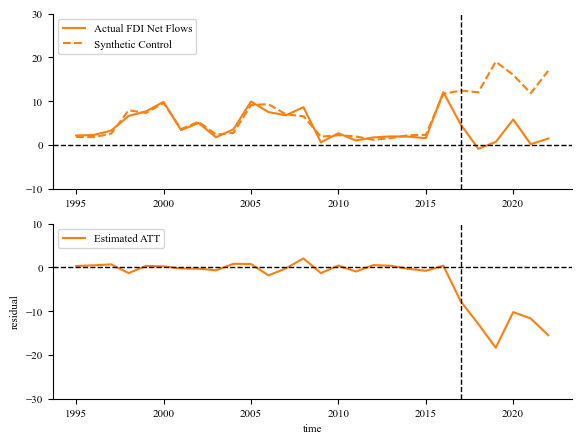

In [153]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

ax1.plot(data.query("tr_group==1").groupby('time').fdi.mean(), color=colors[1], label='Actual FDI Net Flows')
ax1.plot(data.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=data.query("post_period==0").time.max() + 1, color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.legend(loc='upper left')
ax1.set(ylim=(-10, 30))

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')

ax2.axvline(x=data.query("post_period==0").time.max() + 1, color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(loc='upper left')
ax2.set(ylim=(-30, 10))

sns.despine()

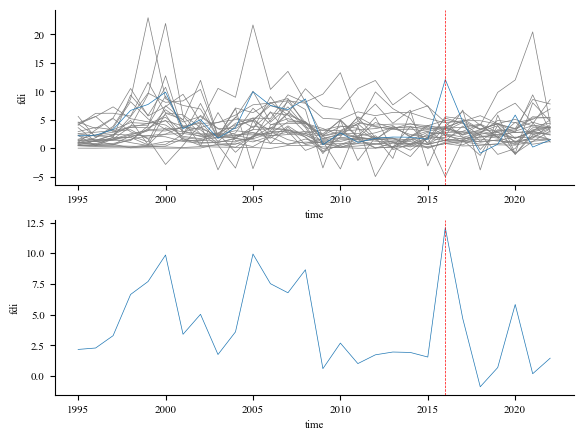

In [154]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=data.query("tr_group==0"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=data.query("tr_group==1"), x='time', y='fdi', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=data.query("tr_group==1"), x='time', y='fdi', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

In [155]:
# specify the null hypothesis
nulls = np.linspace(-60, 60, 100)
# estimate the confidence interval use the function class
ci_test = model.inference(nulls, alpha=0.1, n_jobs=-1, verbose=True)

Estimation for period 2022 is completed!
Estimation for period 2018 is completed!
Estimation for period 2020 is completed!
Estimation for period 2017 is completed!
Estimation for period 2019 is completed!
Estimation for period 2021 is completed!


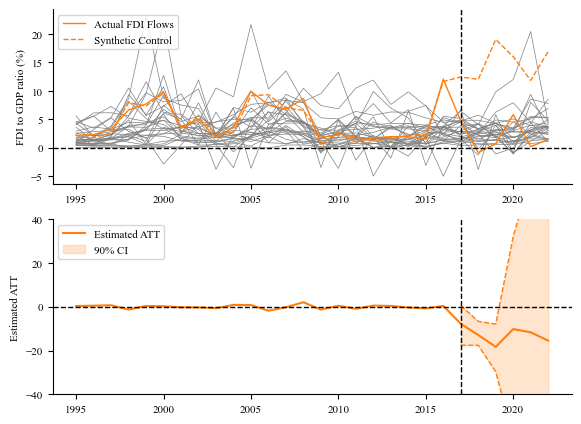

In [156]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=data.query("tr_group==0"), x='time', y='fdi', units='country', estimator=None, ax=ax1, legend=False, color=colors[7], linewidth=0.5)
ax1.plot(data.query("tr_group==1").groupby('time').fdi.mean(), color=colors[1], label='Actual FDI Flows', linewidth=1)

ax1.plot(data.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--', linewidth=1)
ax1.axvline(x=data.query("post_period==0").time.max()+1, color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set(ylabel='FDI to GDP ratio (%)', xlabel='')
ax1.legend(loc='upper left')

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')
ax2.fill_between(ci_test.index, ci_test["90_ci_lower"], ci_test["90_ci_upper"], 
                 alpha=0.2, color="C1", label='90% CI')

# Plotting the upper and lower edges with dotted lines
ax2.plot(ci_test.index, ci_test["90_ci_lower"], linestyle='--', color='C1', linewidth=1)
ax2.plot(ci_test.index, ci_test["90_ci_upper"], linestyle='--', color='C1', linewidth=1)
ax2.axvline(x=data.query("post_period==0").time.max()+1, color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set(ylim=(-40, 40), ylabel='Estimated ATT', xlabel='')
ax2.legend(loc='upper left')

sns.despine()
# save the figure
plt.savefig('figs/ukfdi_ipca.png', dpi=300)